## Genetic compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.genetic import GeneticController
from utils.plot import *

Setting parameters (for the genetic search settings look in `utils.genetic_config.py`)

In [2]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings 
NET_PATH = './models/lenet/saves/lenet.save'

# ga iter count
NUM_GENERATIONS = 36
NUM_PULATION = 12

# ga search settings
CHROMOSOME_RANGES = [range(1, 51) for _ in range(5)]

# ga save settings
SAVE_EVOL_FILE = './results/test_GA_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = './results/lenet-layer-perf.csv'

# range optimization settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = [0, 0, 0, 0, 0]
PREC_REDUCT = None # ['f4', 'f4', 'f4', 'f4', 'f4']

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
def fitness_fc(individual):
    # reset the net
    get_trained(model, NET_PATH, train_settings, DEVICE)
    ws_controller.reset()
    
    # share weigts by chromosome
    individual.data = ws_controller.share(individual.chromosome, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT)

    # compute fitness
    if individual.data['accuracy'] <= 0.95:
        return individual.data['accuracy']

    return 1 / math.sqrt(pow(1 - ((individual.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (individual.data['compression']/14), 2))


Defining logging function and elit dealing function

In [6]:
data = {
    'generation': [],
    'fitness': [],
    'chromosome': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'generation' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

evol_data = pd.read_csv(SAVE_EVOL_FILE).astype(data_types) if os.path.exists(SAVE_EVOL_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(gen_cont:GeneticController):
    global evol_data

    new_data = copy.deepcopy(data)

    for indiv in gen_cont.population:

        new_data['generation'].append(gen_cont.generation)
        new_data['fitness'].append(indiv.fitness)
        new_data['chromosome'].append(indiv.chromosome)
        new_data['accuracy'].append(indiv.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
        new_data['compression'].append(indiv.data['compression'])
        new_data['share_t'].append(indiv.data['times']['share'])
        new_data['train_t'].append(indiv.data['times']['train'])
        new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    evol_data = evol_data.append(pd.DataFrame(new_data).astype(data_types))
    if gen_cont.generation % SAVE_EVERY == SAVE_EVERY - 1:
        evol_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_EVOL_FILE), exist_ok=True)
        evol_data.to_csv(SAVE_EVOL_FILE, index=False)
    
def deal_elit(population):
    for individual in population:
        if individual.data is not None:
            individual.data['times'] = {
                'share': 0,
                'train': 0,
                'test': 0
            }


Setting ranges with optimization

In [7]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    CHROMOSOME_RANGES = ws_controller.get_optimized_layer_ranges(CHROMOSOME_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE, device=DEVICE)

for c_range in CHROMOSOME_RANGES:
    print(len(c_range))

49
47
47
48
47


Run evolution

In [8]:
genetic = GeneticController(CHROMOSOME_RANGES, NUM_PULATION, fitness_fc)

if evol_data.size != 0:
    genetic.load_from_pd(evol_data)

genetic.run(NUM_GENERATIONS, logger_fc, deal_elit=deal_elit, verbose=True)

Generation 1/36 (1) evaluated, best fitness 2.149952592984681
Generation 2/36 (2) evaluated, best fitness 2.149952592984681
Generation 3/36 (3) evaluated, best fitness 2.4392099519031847
Generation 4/36 (4) evaluated, best fitness 2.4392099519031847
Generation 5/36 (5) evaluated, best fitness 2.4392099519031847
Generation 6/36 (6) evaluated, best fitness 2.546557007778406
Generation 7/36 (7) evaluated, best fitness 2.9051756928176298
Generation 8/36 (8) evaluated, best fitness 3.1316279130248295
Generation 9/36 (9) evaluated, best fitness 3.1316279130248295
Generation 10/36 (10) evaluated, best fitness 3.2120716013915076
Generation 11/36 (11) evaluated, best fitness 3.2120716013915076
Generation 12/36 (12) evaluated, best fitness 3.2321863760831238
Generation 13/36 (13) evaluated, best fitness 3.495135720141527
Generation 14/36 (14) evaluated, best fitness 3.495135720141527
Generation 15/36 (15) evaluated, best fitness 3.495135720141527
Generation 16/36 (16) evaluated, best fitness 3.4

[2, 9, 23, 4, 7]

See output

In [9]:
evol_data

,generation,fitness,chromosome,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,2.149953,"[18, 18, 7, 4, 27]",0.9784,0.0062,8.232974,0.510121,0.0,3.620606
1,0,1.696303,"[25, 30, 19, 11, 14]",0.9856,-0.0010,5.996764,0.883502,0.0,3.626976
2,0,1.671556,"[11, 25, 38, 14, 24]",0.9862,-0.0016,5.850446,1.393618,0.0,4.051587
3,0,1.624747,"[47, 43, 14, 23, 9]",0.9854,-0.0008,5.629214,1.004744,0.0,5.152695
4,0,1.621228,"[36, 14, 5, 38, 50]",0.9788,0.0058,5.890647,0.670693,0.0,3.535979
...,...,...,...,...,...,...,...,...,...
427,35,2.343231,"[2, 24, 23, 3, 28]",0.9626,0.0220,11.122357,1.006964,0.0,4.235283
428,35,2.094666,"[2, 30, 25, 3, 21]",0.9568,0.0278,11.155214,1.050986,0.0,3.772233
429,35,1.866509,"[7, 48, 23, 31, 7]",0.9850,-0.0004,6.799340,1.214610,0.0,3.939454
430,35,1.845966,"[45, 30, 23, 4, 39]",0.9826,0.0020,6.817762,1.125537,0.0,3.890319


Plotting data

Text(0.5, 1.0, 'Genetic Algorithm on LeNet-5')

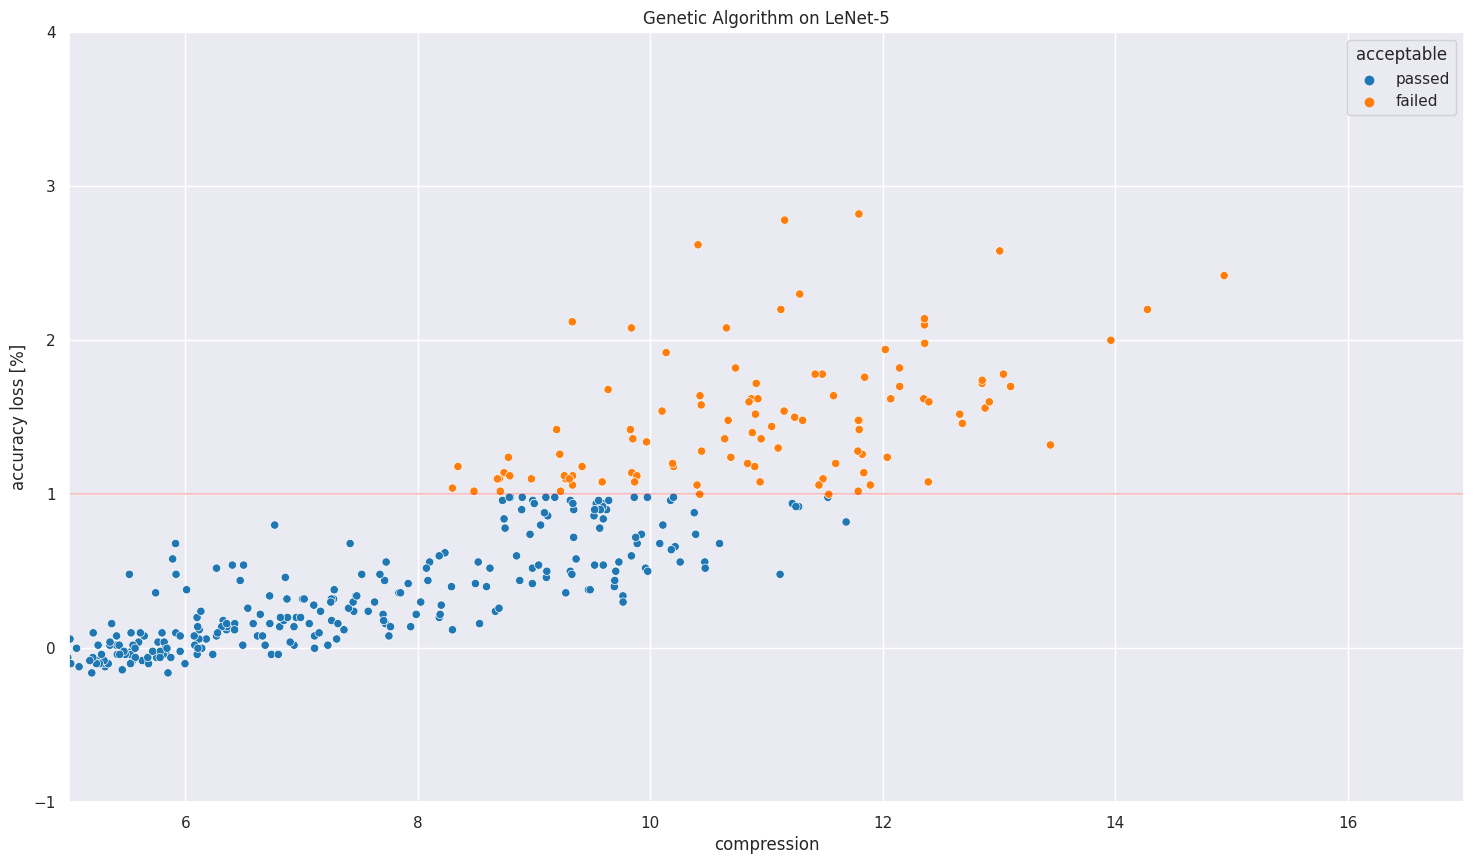

In [10]:
plot_alcr(evol_data)
plt.title('Genetic Algorithm on LeNet-5')